### Load Different Forecast Lengths

Notebook contents 
* in the previous notebook, `7_process..` we created netcdfs from the grib files for all the different forecasts
* in this notebook, we are going to load the netcdfs and compare them as a timeseries

created by Cassie Lumbrazo\
last updated: April 2025\
run location: UAS linux\
python environment: **rasterio**

In [2]:
# import packages 
%matplotlib inline

# plotting packages 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker
import seaborn as sns 
sns.set_theme()
# plt.rcParams['figure.figsize'] = [12,6] #overriding size

# data packages 
import pandas as pd
import numpy as np
import xarray as xr
from datetime import datetime
import scipy
import rioxarray
import rasterio 
import cfgrib

In [3]:
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import ticker

In [4]:
pwd

'/home/cassie/python/repos/juneau_data_analysis'

### Load the HRRR-AK Datasets

In [86]:
filepath = "/hdd/snow_hydrology/hrrrak/netcdf/"

filename_f123 = "hrrrak_merged_grib_f123_WY2024.nc" # this one has a different data structure and datetime range 
filename_f567 = "hrrrak_merged_grib_f567_WY2024_test1.nc"
filename_f678 = "hrrrak_merged_grib_f678_WY2024_test1.nc"
filename_f6to11 = "hrrrak_merged_grib_f6to11_WY2024_test1.nc"
filename_f6to29 = "hrrrak_merged_grib_f6to29_WY2024_test1.nc"

# load data
ds_f123 = xr.open_dataset(filepath + filename_f123)
ds_f567 = xr.open_dataset(filepath + filename_f567)
ds_f678 = xr.open_dataset(filepath + filename_f678)
ds_f6to11 = xr.open_dataset(filepath + filename_f6to11)
ds_f6to29 = xr.open_dataset(filepath + filename_f6to29)

Since there were a few forecasts missing variables, the datetimes are all different lengths.\
Might need to do something there...

In [87]:
# clip ds_f123 to the same time range as ds_f567
ds_f123 = ds_f123.sel(time=slice("2023-10-01", "2024-02-15"))

In [88]:
# now need to clear up one last difference, 
# previously missed renaming tp and precip_total, so let's do that for everything except f123 
ds_f567 = ds_f567.rename({"tp": "precip_total"})
ds_f678 = ds_f678.rename({"tp": "precip_total"})
ds_f6to11 = ds_f6to11.rename({"tp": "precip_total"})
ds_f6to29 = ds_f6to29.rename({"tp": "precip_total"})

In [89]:
# Grab the gridcell closest to the Powder Patch for all the datasets
lat_powderpatch = 58.26200
lon_powderpatch = -134.51700

ds_f123 = ds_f123.assign_coords({"y": ds_f123.latitude[:, 0], "x": ds_f123.longitude[0, :]})
ds_f123.rio.write_crs("EPSG:4326", inplace=True)
ds_f123.rio.crs
ds_f123_pp = ds_f123.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest') 

ds_f567 = ds_f567.assign_coords({"y": ds_f567.latitude[:, 0], "x": ds_f567.longitude[0, :]})
ds_f567.rio.write_crs("EPSG:4326", inplace=True)
ds_f567.rio.crs
ds_f567_pp = ds_f567.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest') 

ds_f678 = ds_f678.assign_coords({"y": ds_f678.latitude[:, 0], "x": ds_f678.longitude[0, :]})
ds_f678.rio.write_crs("EPSG:4326", inplace=True)
ds_f678.rio.crs
ds_f678_pp = ds_f678.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest') 

ds_f6to11 = ds_f6to11.assign_coords({"y": ds_f6to11.latitude[:, 0], "x": ds_f6to11.longitude[0, :]})
ds_f6to11.rio.write_crs("EPSG:4326", inplace=True)
ds_f6to11.rio.crs
ds_f6to11_pp = ds_f6to11.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest') 

ds_f6to29 = ds_f6to29.assign_coords({"y": ds_f6to29.latitude[:, 0], "x": ds_f6to29.longitude[0, :]})
ds_f6to29.rio.write_crs("EPSG:4326", inplace=True)
ds_f6to29.rio.crs
ds_f6to29_pp = ds_f6to29.sel(y=lat_powderpatch, x=lon_powderpatch, method='nearest') 

### Load the Powder Patch Met Station Data

In [186]:
filename = '/home/cassie/data/fishcreek/mesonet/rawdata/DouglasIsland_AllStations_RawData_WY2024.txt'
# filename = '/home/cassie/data/fishcreek/mesonet/rawdata/DouglasIsland_AllStations_RawData_WY2025_until16March2025.txt'

# LOAD DATA
df_met = pd.read_csv(filename, sep = ",")

# make utc_valid a datetime and index the df_met by it 
df_met['datetime'] = pd.to_datetime(df_met['utc_valid'])
df_met = df_met.set_index('datetime')

<Axes: xlabel='datetime'>

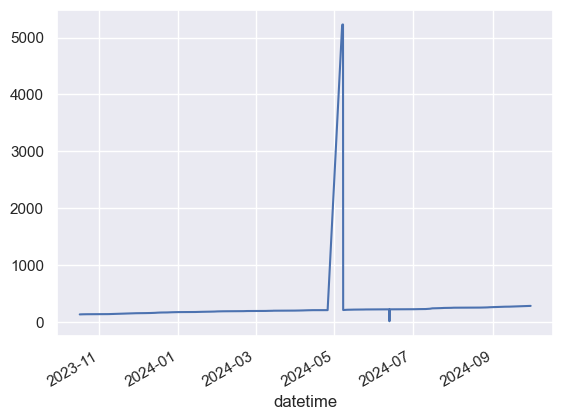

In [187]:
df_met['PCIRZZZ'].where(df_met['station'] == 'PPSA2').plot()

In [188]:
# LIGHT CLEANING
# drop PCIRZZZ values above 1000 
df_met['PCIRZZZ'] = df_met['PCIRZZZ'].where(df_met['PCIRZZZ'] < 1000) # only keep values below 100
df_met['PCIRZZZ'] = df_met['PCIRZZZ'].where(df_met['PCIRZZZ'] > 125) # only keep values above 100

df_met['PPDRZZZ'] = df_met['PPDRZZZ'].where(df_met['PPDRZZZ'] > -1000)
df_met['PPIRZZZ'] = df_met['PPIRZZZ'].where(df_met['PPIRZZZ'] > -1000)
df_met['PPPRZZZ'] = df_met['PPPRZZZ'].where(df_met['PPPRZZZ'] > -1000)
df_met['PPVRZZZ'] = df_met['PPVRZZZ'].where(df_met['PPVRZZZ'] > -1000)

# drop any SDIRZZZ values above 1000, for now 
df_met['SDIRZZZ'] = df_met['SDIRZZZ'].where(df_met['SDIRZZZ'] < 1000)

# CREATE A PP DATASET ONLY 
# create a new dataframe with only PPSA2 station data
df_met_pp = df_met[df_met['station'] == 'PPSA2']
df_met_pp = df_met_pp.dropna(axis=1, how='all')

# calculate precip_rate from precip_accum
df_met_pp['PPIRZZZ'] = df_met_pp['PCIRZZZ'].diff() # subtract the previus value to get the difference 

# then drop any values about 10 
df_met_pp['PPIRZZZ'] = df_met_pp['PPIRZZZ'].where(df_met_pp['PPIRZZZ'] < 1)
df_met_pp


station            utc_valid  PCIRZZZ  SDIRZZZ  TAIRZZZ  \
datetime                                                                      
2023-10-16 18:00:00   PPSA2  2023-10-16 18:00:00   128.62     0.00     49.7   
2023-10-16 19:00:00   PPSA2  2023-10-16 19:00:00   128.62     0.00     50.5   
2023-10-16 20:00:00   PPSA2  2023-10-16 20:00:00   128.62     0.00     48.2   
2023-10-16 21:00:00   PPSA2  2023-10-16 21:00:00   128.62     0.00     48.3   
2023-10-16 22:00:00   PPSA2  2023-10-16 22:00:00   128.62     0.00     48.4   
...                     ...                  ...      ...      ...      ...   
2024-09-29 20:00:00   PPSA2  2024-09-29 20:00:00   278.46    14.36     40.4   
2024-09-29 21:00:00   PPSA2  2024-09-29 21:00:00   278.46    16.34     39.9   
2024-09-29 22:00:00   PPSA2  2024-09-29 22:00:00   278.46    16.56     40.4   
2024-09-29 23:00:00   PPSA2  2024-09-29 23:00:00   278.46    15.25     40.8   
2024-09-30 00:00:00   PPSA2  2024-09-30 00:00:00   278.46    16.56     40.2   

                     XRIRZZZ  PPIRZZZ  
datetime                               
2023-10-16 18:00:00    63.04      NaN  
2023-10-16 19:00:00    59.44      0.0  
2023-10-16 20:00:00    72.65      0.0  
2023-10-16 21:00:00    71.85      0.0  
2023-10-16 22:00:00    72.42      0.0  
...                      ...      ...  
2024-09-29 20:00:00    91.40      0.0  
2024-09-29 21:00:00    88.20      0.0  
2024-09-29 22:00:00    88.60      0.0  
2024-09-29 23:00:00    88.00      0.0  
2024-09-30 00:00:00    88.40      0.0  

[7632 rows x 7 columns]

<Axes: xlabel='datetime'>

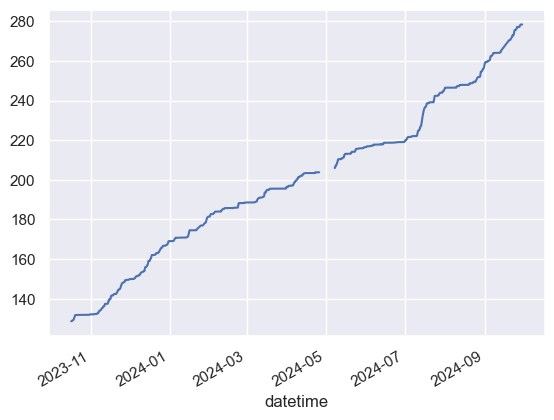

In [189]:
df_met['PCIRZZZ'].where(df_met['station'] == 'PPSA2').plot()

In [ ]:
# first save all the hourly datasets so this is easier to read and follow
PC_PPSA2 = (df_met['PCIRZZZ']*25.4).where(df_met['station'] == 'PPSA2').resample('h').mean()
# drop the weird value in PC_PPSA2 which is less than 100 
# PC_PPSA2 = PC_PPSA2.where(PC_PPSA2 > 100)

PC_SDIA2 = (df_met['PCIRZZZ']*25.4).where(df_met['station'] == 'SDIA2').resample('h').mean()
PP_ECEA2 = (df_met['PPIRZZZ']*25.4).where(df_met['station'] == 'ECEA2').resample('h').mean()

# put all of these into a dataset together 
# create an empty pandas dataframe 
df_precip = pd.DataFrame()
df_precip['PC_PPSA2'] = PC_PPSA2.copy()
df_precip['PC_SDIA2'] = PC_SDIA2.copy()
df_precip['PP_ECEA2'] = PP_ECEA2.copy()
df_precip.head() 

PC_PPSA2  PC_SDIA2  PP_ECEA2
datetime                                         
2023-10-01 00:00:00       NaN       NaN  0.254000
2023-10-01 01:00:00       NaN       NaN  0.423333
2023-10-01 02:00:00       NaN       NaN  0.677333
2023-10-01 03:00:00       NaN       NaN  1.608667
2023-10-01 04:00:00       NaN       NaN  3.302000

<Axes: title={'center': 'Hourly Precipitation at Powder Patch'}, xlabel='datetime'>

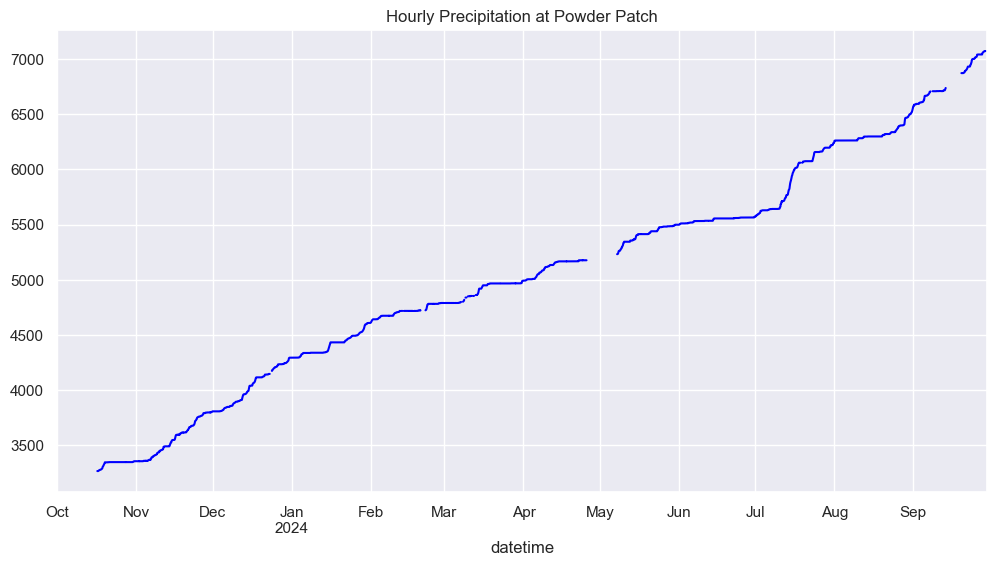

In [140]:
df_precip.PC_PPSA2.plot(label='PC_PPSA2', color='blue', figsize=(12, 6), title='Hourly Precipitation at Powder Patch')

In [92]:
# now calculate the rate from the cumulative precipitation
df_precip['PR_PPSA2'] = df_precip['PC_PPSA2'].diff()  # Calculate the difference to get the rate
df_precip['PR_SDIA2'] = df_precip['PC_SDIA2'].diff()  # Calculate the difference to get the rate,
 
df_precip['PR_ECEA2'] = df_precip['PP_ECEA2'].diff()  # this one is daily accumulation so not sure....
df_precip['PR_ECEA2'] = df_precip['PR_ECEA2'].where(df_precip['PR_ECEA2'] >=0, df_precip['PP_ECEA2'])  # need to handle the daily rests 

# df_precip['PC_ECEA2'] = df_precip['PP_ECEA2'].cumsum()
df_precip['PC_ECEA2'] = df_precip['PR_ECEA2'].cumsum()

df_precip.head()

PC_PPSA2  PC_SDIA2  PP_ECEA2  PR_PPSA2  PR_SDIA2  \
datetime                                                                
2023-10-01 00:00:00       NaN       NaN  0.254000       NaN       NaN   
2023-10-01 01:00:00       NaN       NaN  0.423333       NaN       NaN   
2023-10-01 02:00:00       NaN       NaN  0.677333       NaN       NaN   
2023-10-01 03:00:00       NaN       NaN  1.608667       NaN       NaN   
2023-10-01 04:00:00       NaN       NaN  3.302000       NaN       NaN   

                     PR_ECEA2  PC_ECEA2  
datetime                                 
2023-10-01 00:00:00  0.254000  0.254000  
2023-10-01 01:00:00  0.169333  0.423333  
2023-10-01 02:00:00  0.254000  0.677333  
2023-10-01 03:00:00  0.931333  1.608667  
2023-10-01 04:00:00  1.693333  3.302000

In [93]:
# all datasets to the same date range
start_date = '2023-10-01 01:00'
end_date = '2024-02-15 00:00'

# select the date range for all datasets
df_precip = df_precip.loc[start_date:end_date]
ds_f123_pp = ds_f123_pp.sel(time=slice(start_date, end_date))
ds_f567_pp = ds_f567_pp.sel(time=slice(start_date, end_date))
ds_f678_pp = ds_f678_pp.sel(time=slice(start_date, end_date))
ds_f6to29_pp = ds_f6to29_pp.sel(time=slice(start_date, end_date))
ds_f6to11_pp = ds_f6to11_pp.sel(time=slice(start_date, end_date))

# # but also need to make sure they are all the same length with no missing datetimes
# # resample the datasets to hourly frequency
# ds_f123_pp = ds_f123_pp.resample(time='1h').mean()
# ds_f567_pp = ds_f567_pp.resample(time='1h').mean()
# ds_f678_pp = ds_f678_pp.resample(time='1h').mean()
# ds_f6to29_pp = ds_f6to29_pp.resample(time='1h').mean()
# ds_f6to11_pp = ds_f6to11_pp.resample(time='1h').mean()
# # and the precip dataframe to hourly frequency
# df_precip = df_precip.resample('h').mean()

In [95]:
# df_precip['precip_rate_hrrrak_f123'] = ds_f123_pp['precip_total'].values
# df_precip['precip_accu_hrrrak_f123'] = ds_f123_pp['precip_total'].cumsum().values

# df_precip['precip_rate_hrrrak_f567'] = ds_f567_pp['precip_total'].values
# df_precip['precip_accu_hrrrak_f567'] = ds_f567_pp['precip_total'].cumsum().values
# df_precip['precip_rate_hrrrak_f678'] = ds_f678_pp['precip_total'].values
# df_precip['precip_accu_hrrrak_f678'] = ds_f678_pp['precip_total'].cumsum().values
# df_precip['precip_rate_hrrrak_f6to11'] = ds_f6to11_pp['precip_total'].values
# df_precip['precip_accu_hrrrak_f6to11'] = ds_f6to11_pp['precip_total'].cumsum().values
# df_precip['precip_rate_hrrrak_f6to29'] = ds_f6to29_pp['precip_total'].values
# df_precip['precip_accu_hrrrak_f6to29'] = ds_f6to29_pp['precip_total'].cumsum().values

## Plot a few variables,

In [58]:
ds_f567

<xarray.Dataset> Size: 289MB
Dimensions:                  (time: 3311, y: 20, x: 21)
Coordinates:
  * time                     (time) datetime64[ns] 26kB 2023-10-01T05:00:00 ....
    step                     (time) timedelta64[ns] 26kB ...
    valid_time               (time) datetime64[ns] 26kB ...
    latitude                 (y, x) float64 3kB ...
    longitude                (y, x) float64 3kB ...
    boundaryLayerCloudLayer  float64 8B 0.0
  * y                        (y) float64 160B 58.08 58.11 58.14 ... 58.56 58.59
  * x                        (x) float64 168B 225.1 225.1 225.2 ... 226.0 226.1
    spatial_ref              int64 8B 0
Data variables: (12/52)
    pt                       (time, y, x) float32 6MB ...
    temp                     (time, y, x) float32 6MB ...
    d2m                      (time, y, x) float32 6MB ...
    sh2                      (time, y, x) float32 6MB ...
    rh                       (time, y, x) float32 6MB ...
    u10                      (time, y, x) float32 6MB ...
    ...                       ...
    lai                      (time, y, x) float32 6MB ...
    vgtyp                    (time, y, x) float32 6MB ...
    cloud_total              (time, y, x) float32 6MB ...
    cloud_high               (time, y, x) float32 6MB ...
    cloud_low                (time, y, x) float32 6MB ...
    wind                     (time, y, x) float32 6MB ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP

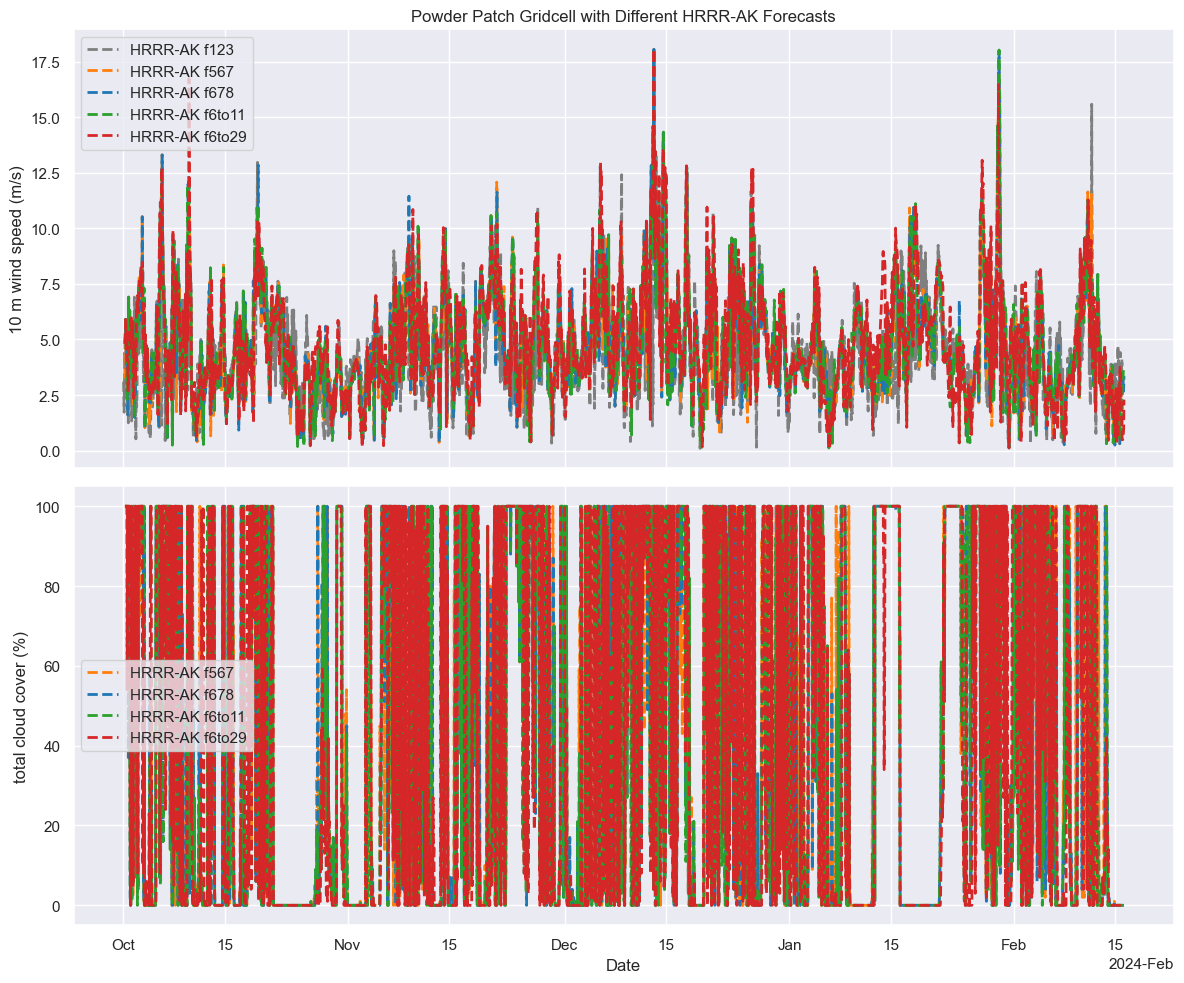

In [59]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ds_f123_pp['wind'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey')
ds_f567_pp['wind'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
ds_f678_pp['wind'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
ds_f6to11_pp['wind'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
ds_f6to29_pp['wind'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

# ds_f123_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey') # no cloud cover downloaded for f123
ds_f567_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
ds_f678_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
ds_f6to11_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
ds_f6to29_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('10 m wind speed (m/s)')
ax[1].set_ylabel('total cloud cover (%)')
ax[0].set_title('Powder Patch Gridcell with Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()
plt.tight_layout()

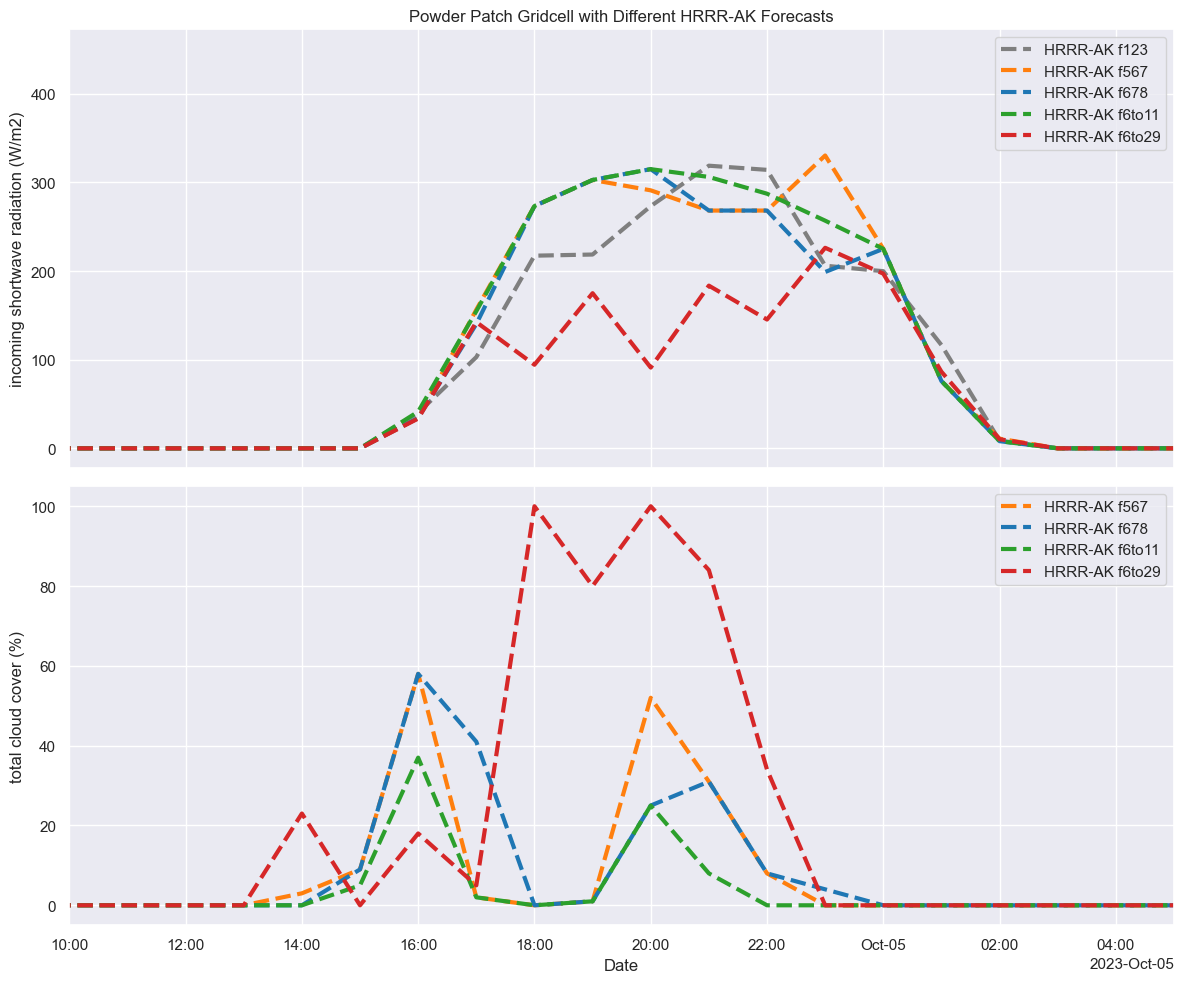

In [177]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ds_f123_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

# ds_f123_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey') # no cloud cover downloaded for f123
ds_f567_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['cloud_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('incoming shortwave radiation (W/m2)')
ax[1].set_ylabel('total cloud cover (%)')
ax[0].set_title('Powder Patch Gridcell with Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()

# zoom into a single day 
# start_date = '2023-12-20 00:00'
# end_date = '2023-12-29 00:00'
# start_date = '2023-10-04 10:00'
# end_date = '2023-10-07 05:00'
start_date = '2023-10-04 10:00'
end_date = '2023-10-05 05:00'
ax[0].set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

plt.tight_layout()

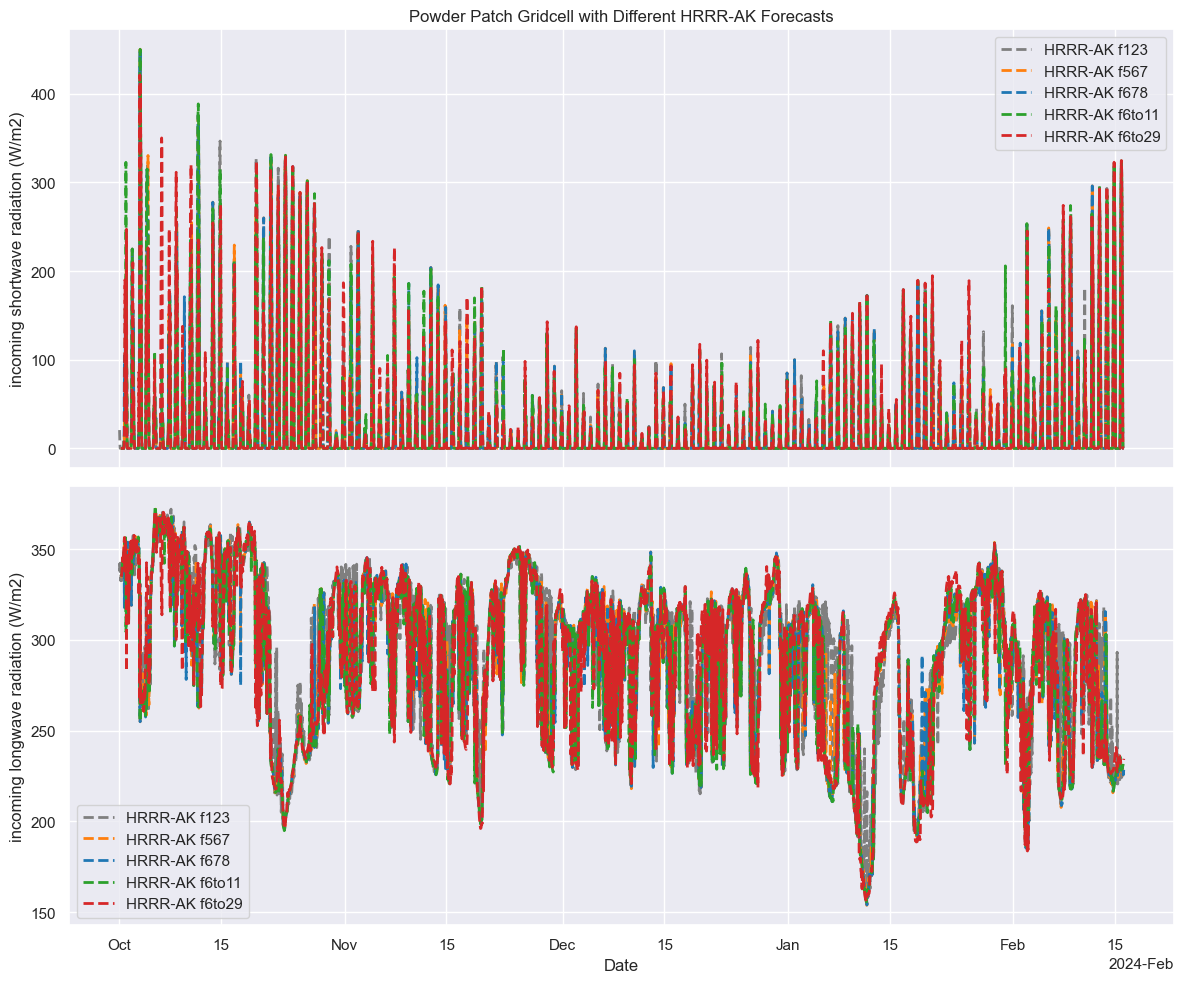

In [60]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ds_f123_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey')
ds_f567_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
ds_f678_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
ds_f6to11_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
ds_f6to29_pp['swrad'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

ds_f123_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey')
ds_f567_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
ds_f678_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
ds_f6to11_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
ds_f6to29_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('incoming shortwave radiation (W/m2)')
ax[1].set_ylabel('incoming longwave radiation (W/m2)')
ax[0].set_title('Powder Patch Gridcell with Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()
plt.tight_layout()


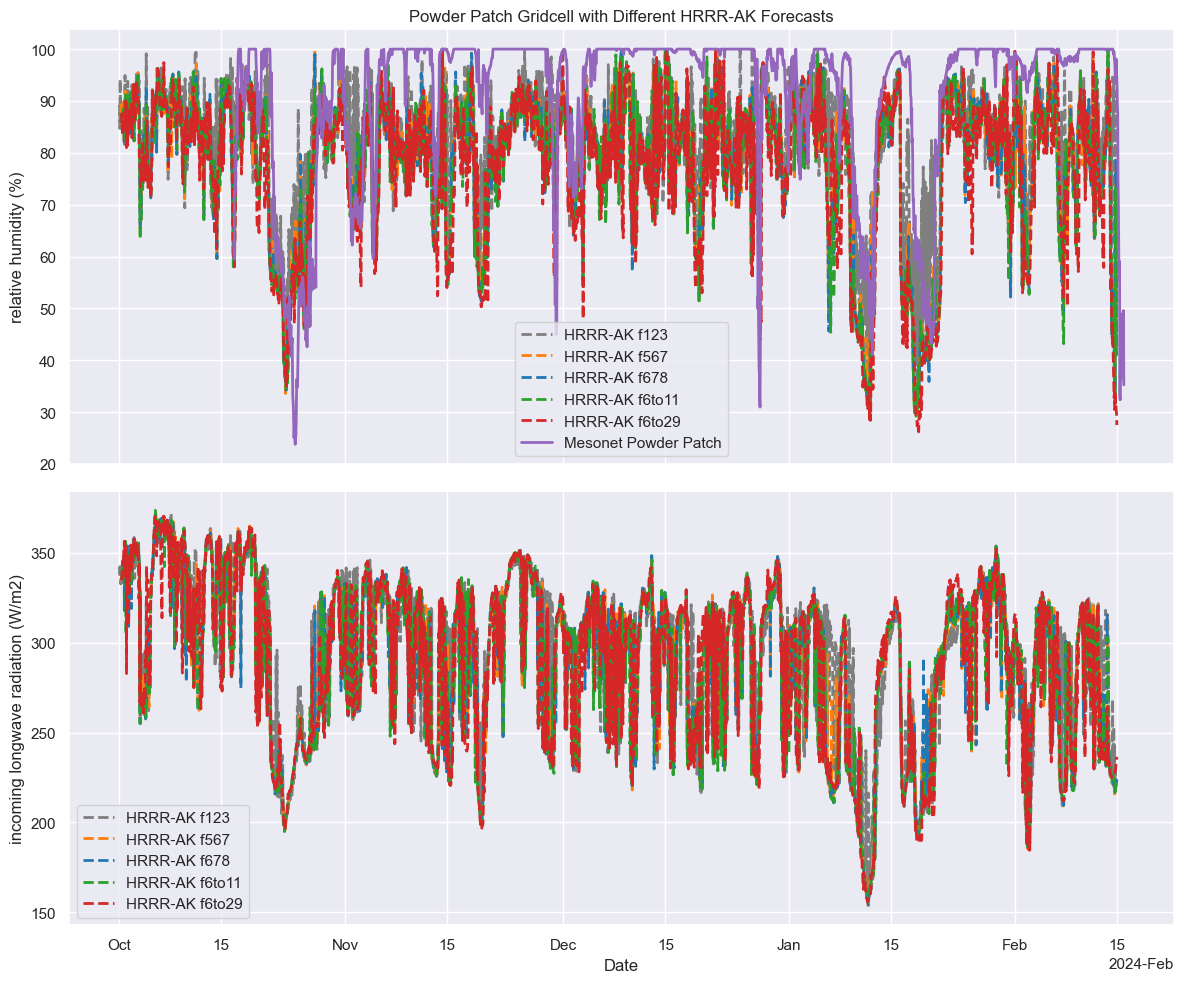

In [202]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

ds_f123_pp['rh'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey')
ds_f567_pp['rh'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
ds_f678_pp['rh'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
ds_f6to11_pp['rh'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
ds_f6to29_pp['rh'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

df_met_pp['XRIRZZZ'].plot(ax=ax[0], linestyle='-', label='Mesonet Powder Patch', linewidth=2, color='tab:purple')


ds_f123_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey')
ds_f567_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
ds_f678_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
ds_f6to11_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
ds_f6to29_pp['lwrad'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('relative humidity (%)')
ax[1].set_ylabel('incoming longwave radiation (W/m2)')
ax[0].set_title('Powder Patch Gridcell with Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()
plt.tight_layout()


In [193]:
df_met_pp['temp_C'] = (df_met_pp['TAIRZZZ'] - 32) * 5/9  # convert from F to C
df_met_pp

station            utc_valid  PCIRZZZ  SDIRZZZ  TAIRZZZ  \
datetime                                                                      
2023-10-16 18:00:00   PPSA2  2023-10-16 18:00:00   128.62     0.00     49.7   
2023-10-16 19:00:00   PPSA2  2023-10-16 19:00:00   128.62     0.00     50.5   
2023-10-16 20:00:00   PPSA2  2023-10-16 20:00:00   128.62     0.00     48.2   
2023-10-16 21:00:00   PPSA2  2023-10-16 21:00:00   128.62     0.00     48.3   
2023-10-16 22:00:00   PPSA2  2023-10-16 22:00:00   128.62     0.00     48.4   
...                     ...                  ...      ...      ...      ...   
2024-09-29 20:00:00   PPSA2  2024-09-29 20:00:00   278.46    14.36     40.4   
2024-09-29 21:00:00   PPSA2  2024-09-29 21:00:00   278.46    16.34     39.9   
2024-09-29 22:00:00   PPSA2  2024-09-29 22:00:00   278.46    16.56     40.4   
2024-09-29 23:00:00   PPSA2  2024-09-29 23:00:00   278.46    15.25     40.8   
2024-09-30 00:00:00   PPSA2  2024-09-30 00:00:00   278.46    16.56     40.2   

                     XRIRZZZ  PPIRZZZ     temp_C  
datetime                                          
2023-10-16 18:00:00    63.04      NaN   9.833333  
2023-10-16 19:00:00    59.44      0.0  10.277778  
2023-10-16 20:00:00    72.65      0.0   9.000000  
2023-10-16 21:00:00    71.85      0.0   9.055556  
2023-10-16 22:00:00    72.42      0.0   9.111111  
...                      ...      ...        ...  
2024-09-29 20:00:00    91.40      0.0   4.666667  
2024-09-29 21:00:00    88.20      0.0   4.388889  
2024-09-29 22:00:00    88.60      0.0   4.666667  
2024-09-29 23:00:00    88.00      0.0   4.888889  
2024-09-30 00:00:00    88.40      0.0   4.555556  

[7632 rows x 8 columns]

In [198]:
# select only certain dates for df_met_pp
start_date = '2023-10-01 00:00'
end_date = '2024-02-15'
df_met_pp = df_met_pp.loc[start_date:end_date]

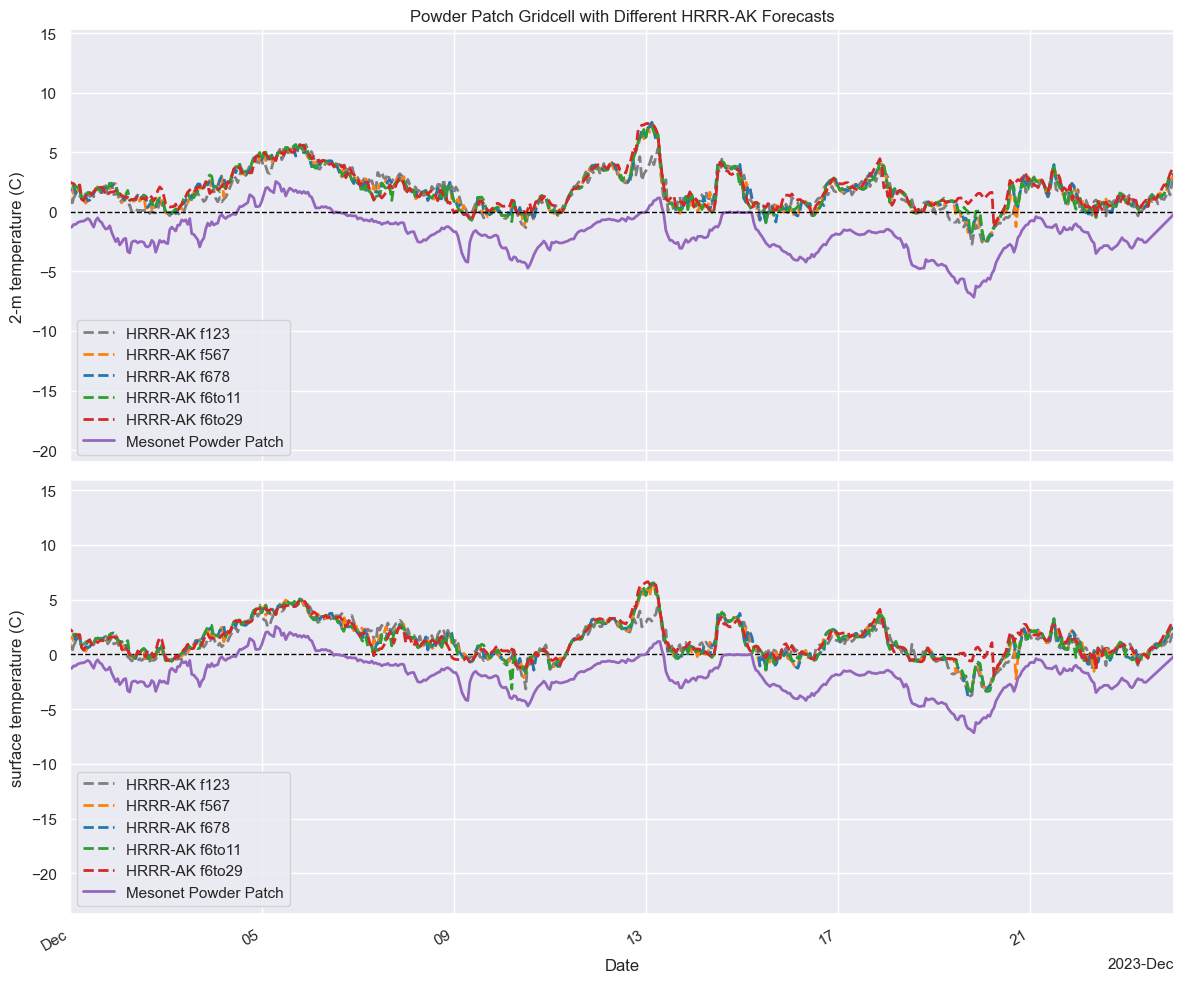

In [201]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)

(ds_f123_pp['temp']-273.5).plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey')
(ds_f567_pp['temp']-273.5).plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
(ds_f678_pp['temp']-273.5).plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
(ds_f6to11_pp['temp']-273.5).plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
(ds_f6to29_pp['temp']-273.5).plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

df_met_pp['temp_C'].plot(ax=ax[0], linestyle='-', label='Mesonet Powder Patch', linewidth=2, color='tab:purple')

# plot a zero line 
ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
ax[1].axhline(0, color='black', linestyle='--', linewidth=1)

(ds_f123_pp['temp_surface']-273.5).plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=2, color='tab:grey')
(ds_f567_pp['temp_surface']-273.5).plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=2, color='tab:orange')
(ds_f678_pp['temp_surface']-273.5).plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=2, color='tab:blue')
(ds_f6to11_pp['temp_surface']-273.5).plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=2, color='tab:green')
(ds_f6to29_pp['temp_surface']-273.5).plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=2, color='tab:red')

df_met_pp['temp_C'].plot(ax=ax[1], linestyle='-', label='Mesonet Powder Patch', linewidth=2, color='tab:purple')


ax[0].set_xlabel('')
ax[1].set_xlabel('Date')
ax[0].set_ylabel('2-m temperature (C)')
ax[1].set_ylabel('surface temperature (C)')
ax[0].set_title('Powder Patch Gridcell with Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()

# zoom into a single day 
# start_date = '2023-12-20 00:00'
# end_date = '2023-12-29 00:00'
start_date = '2023-12-01 00:00'
end_date = '2023-12-24 00:00'
ax[0].set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

# # set y lim 
# ax[0].set_ylim(-5,5)
# ax[1].set_ylim(-5,5)

plt.tight_layout()

Let's look at the different preicpitation variables to understand what they are...

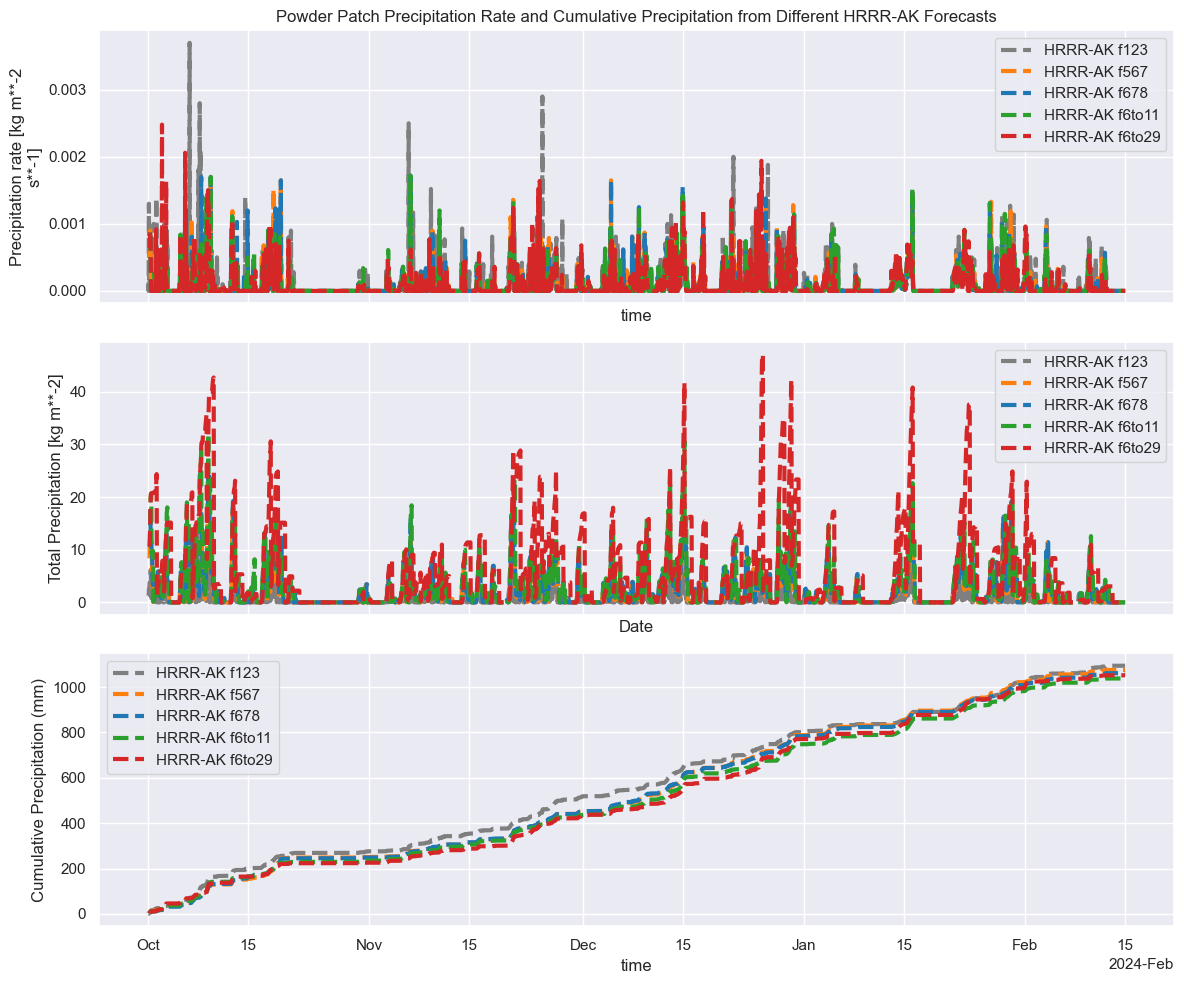

In [113]:
fig, ax = plt.subplots(3, 1, figsize=(12, 10), sharex=True)

ds_f123_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

ds_f123_pp['precip_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_total'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

(ds_f123_pp['precip_rate'].cumsum()*3600).plot(ax=ax[2], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
(ds_f567_pp['precip_rate'].cumsum()*3600).plot(ax=ax[2], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
(ds_f678_pp['precip_rate'].cumsum()*3600).plot(ax=ax[2], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
(ds_f6to11_pp['precip_rate'].cumsum()*3600).plot(ax=ax[2], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
(ds_f6to29_pp['precip_rate'].cumsum()*3600).plot(ax=ax[2], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

ax[1].set_xlabel('Date')
# ax[0].set_ylabel('Precipitation Rate (mm/hr)')
# ax[1].set_ylabel('Precipitation Rate (mm/hr)')
ax[2].set_ylabel('Cumulative Precipitation (mm)')
ax[0].set_title('Powder Patch Precipitation Rate and Cumulative Precipitation from Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[2].set_title('')
ax[0].legend()
ax[1].legend()
ax[2].legend()

# zoom into a single day 
# start_date = '2023-12-20 00:00'
# end_date = '2023-12-29 00:00'
# start_date = '2023-12-20 00:00'
# end_date = '2023-12-24 00:00'
# ax[0].set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

plt.tight_layout()

In [116]:
# calculate cumulative preciptiation 
ds_f123_pp['precip_accum'] = ds_f123_pp['precip_rate'].cumsum()*3600
ds_f567_pp['precip_accum'] = ds_f567_pp['precip_rate'].cumsum()*3600
ds_f678_pp['precip_accum'] = ds_f678_pp['precip_rate'].cumsum()*3600
ds_f6to11_pp['precip_accum'] = ds_f6to11_pp['precip_rate'].cumsum()*3600
ds_f6to29_pp['precip_accum'] = ds_f6to29_pp['precip_rate'].cumsum()*3600

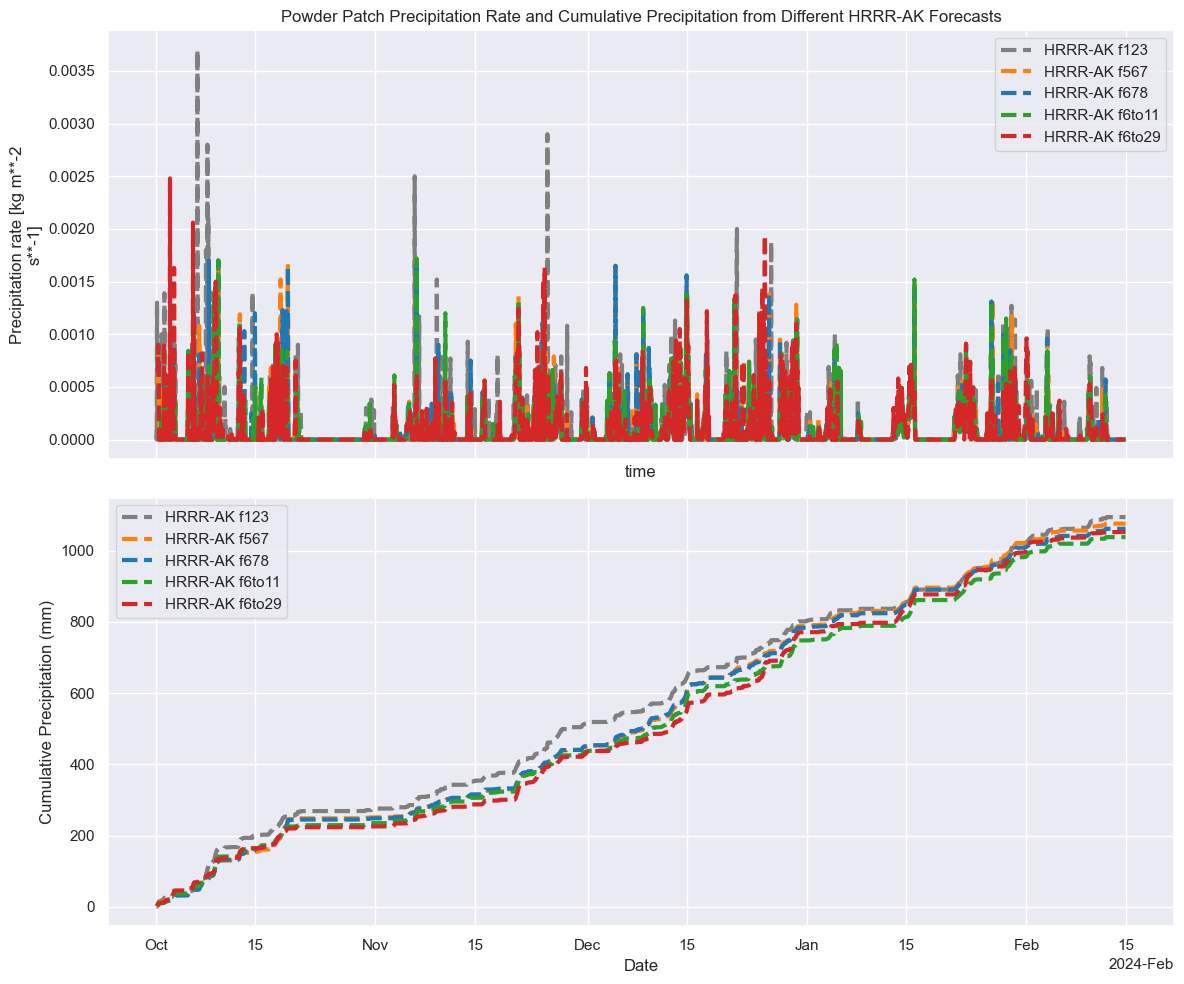

In [117]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ds_f123_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

ds_f123_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

ax[1].set_xlabel('Date')
# ax[0].set_ylabel('Precipitation Rate (mm/hr)')
ax[1].set_ylabel('Cumulative Precipitation (mm)')
ax[0].set_title('Powder Patch Precipitation Rate and Cumulative Precipitation from Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()
plt.tight_layout()


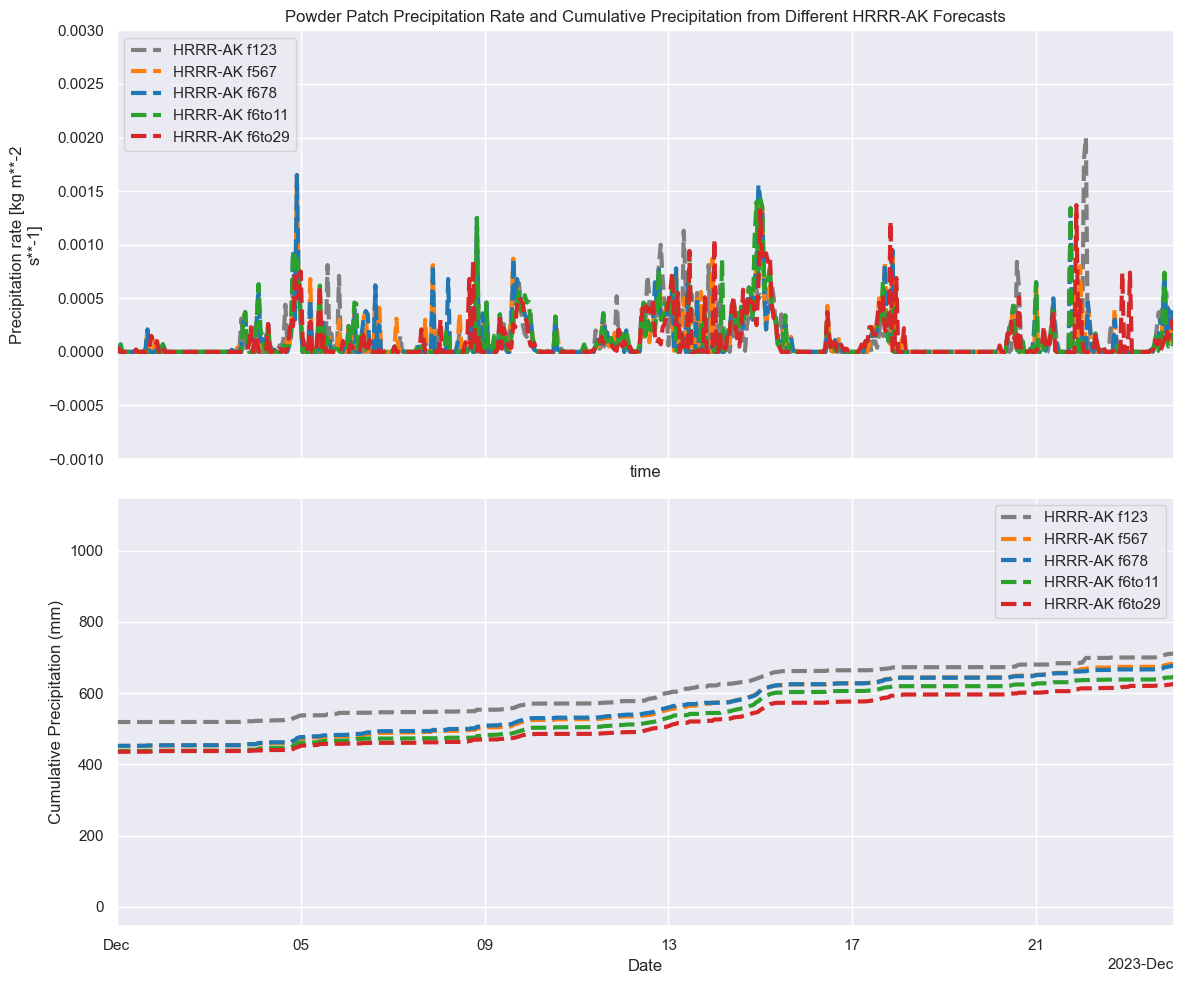

In [214]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ds_f123_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

# (df_met_pp['PCIRZZZ'].diff()*(1/3600)*25.4).plot(ax=ax[0], linestyle='-', label='Mesonet Powder Patch', linewidth=3, color='tab:purple')

ds_f123_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_accum'].plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

ax[1].set_xlabel('Date')
# ax[0].set_ylabel('Precipitation Rate (mm/hr)')
ax[1].set_ylabel('Cumulative Precipitation (mm)')
ax[0].set_title('Powder Patch Precipitation Rate and Cumulative Precipitation from Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()

# start_date = '2023-10-01'
# end_date = '2024-02-15'
start_date = '2023-12-01'
end_date = '2023-12-24'
ax[0].set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

ax[0].set_ylim(-0.001,0.003)

plt.tight_layout()

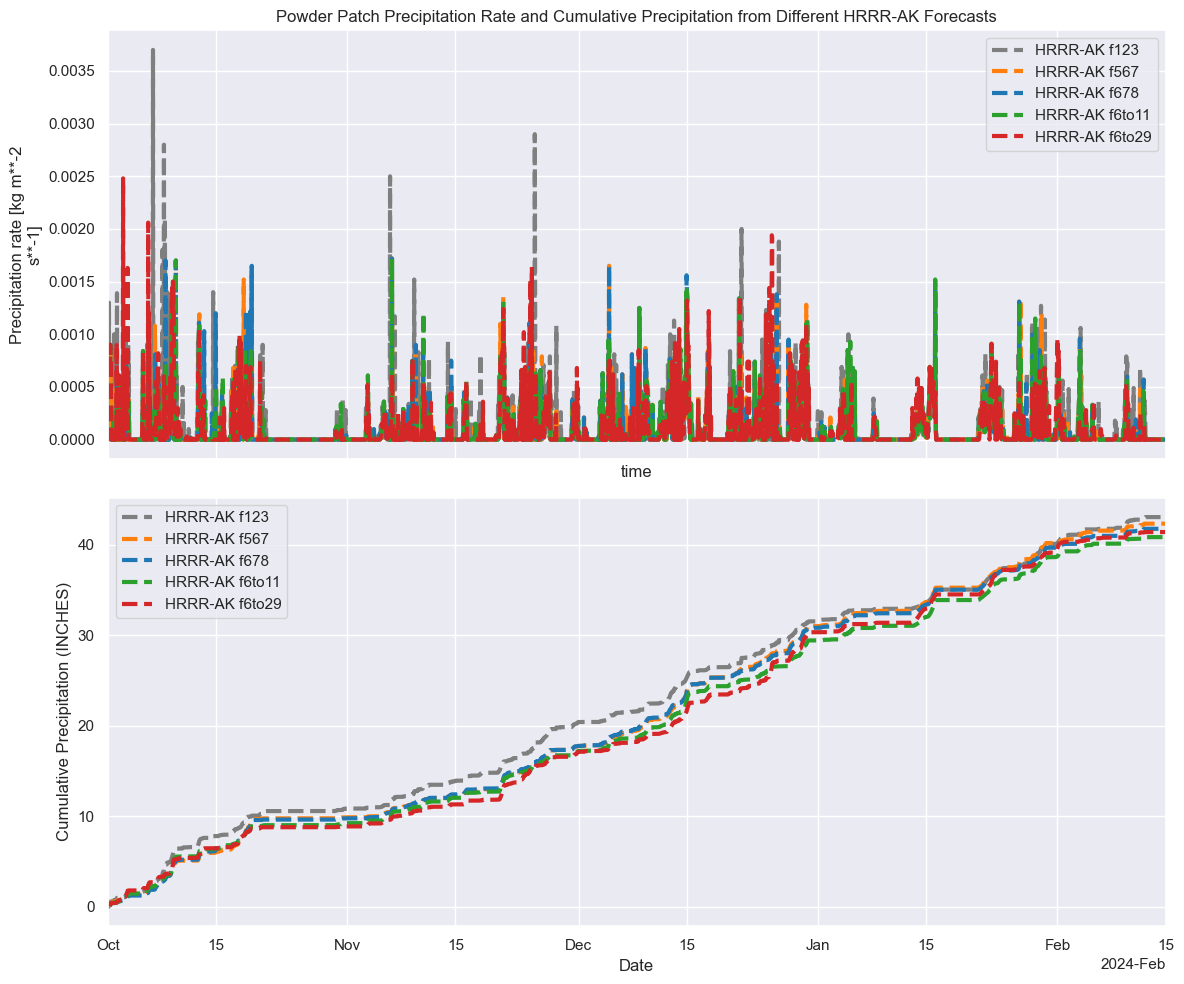

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ds_f123_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

# convert to inches 
num = 0.0393701 # conversion factor from mm to inches
(ds_f123_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
(ds_f567_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
(ds_f678_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
(ds_f6to11_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
(ds_f6to29_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

ax[1].set_xlabel('Date')
# ax[0].set_ylabel('Precipitation Rate (mm/hr)')
ax[1].set_ylabel('Cumulative Precipitation (INCHES)')
ax[0].set_title('Powder Patch Precipitation Rate and Cumulative Precipitation from Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()

plt.tight_layout()

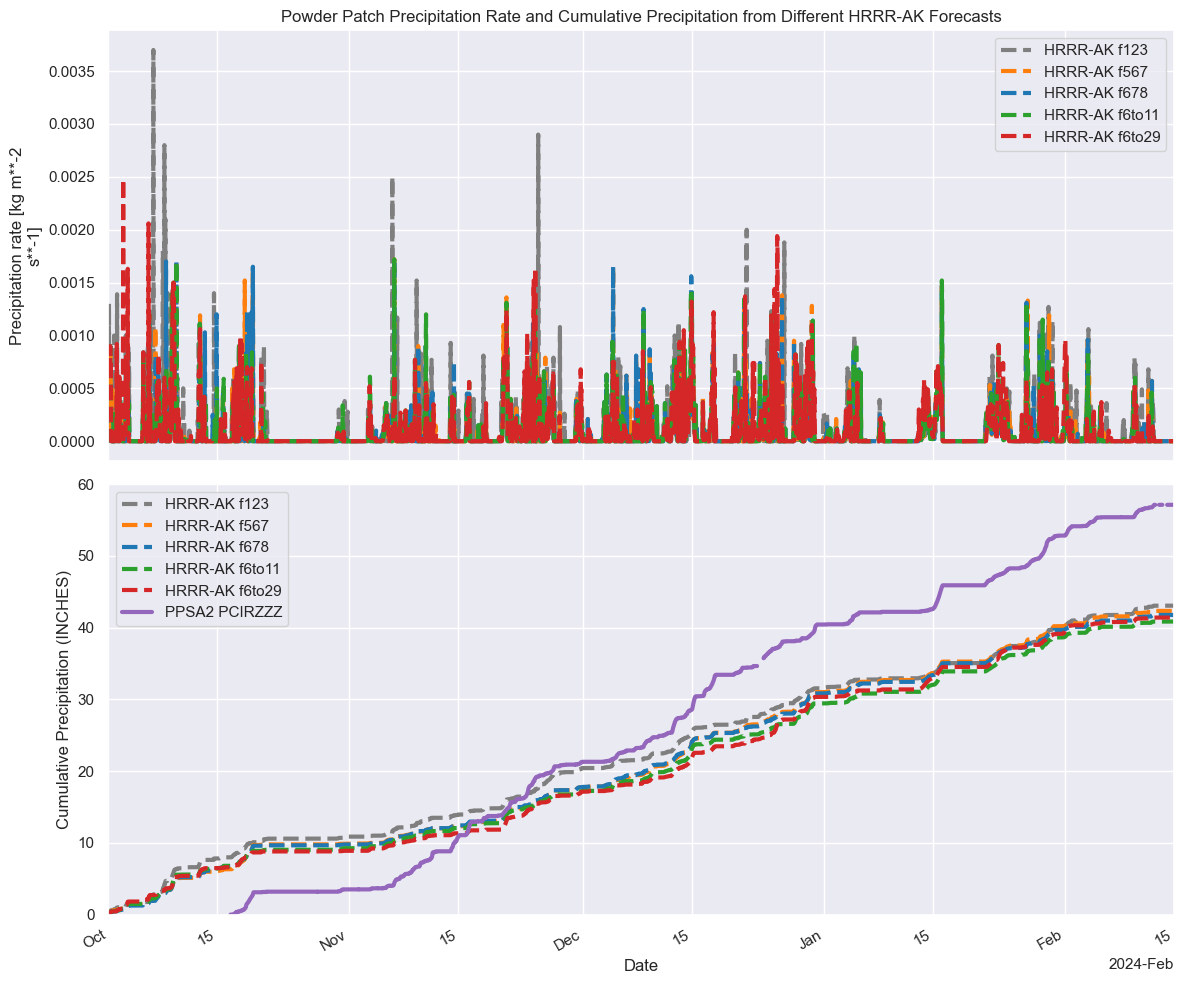

In [152]:
fig, ax = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
ds_f123_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
ds_f567_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
ds_f678_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
ds_f6to11_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
ds_f6to29_pp['precip_rate'].plot(ax=ax[0], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

# convert to inches 
num = 0.0393701 # conversion factor from mm to inches
(ds_f123_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f123', linewidth=3, color='tab:grey')
(ds_f567_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f567', linewidth=3, color='tab:orange')
(ds_f678_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f678', linewidth=3, color='tab:blue')
(ds_f6to11_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to11', linewidth=3, color='tab:green')
(ds_f6to29_pp['precip_accum']*num).plot(ax=ax[1], linestyle='--', label='HRRR-AK f6to29', linewidth=3, color='tab:red')

# df_met['PCIRZZZ'].where(df_met['station'] == 'PPSA2').plot(ax=ax[1], linestyle='-', label='PPSA2 PCIRZZZ', linewidth=3, color='tab:purple')
(df_precip['PC_PPSA2']*num).plot(ax=ax[1], linestyle='-', label='PPSA2 PCIRZZZ', linewidth=3, color='tab:purple')

ax[1].set_xlabel('Date')
# ax[0].set_ylabel('Precipitation Rate (mm/hr)')
ax[1].set_ylabel('Cumulative Precipitation (INCHES)')
ax[0].set_title('Powder Patch Precipitation Rate and Cumulative Precipitation from Different HRRR-AK Forecasts')
ax[1].set_title('')
ax[0].legend()
ax[1].legend()

start_date = '2023-10-01'
end_date = '2024-02-15'
ax[0].set_xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))

# zoom into the yaxis of the second plot 
ax[1].set_ylim(0, 60)  # Adjust the y-axis limits as needed

plt.tight_layout()

<Axes: xlabel='datetime'>

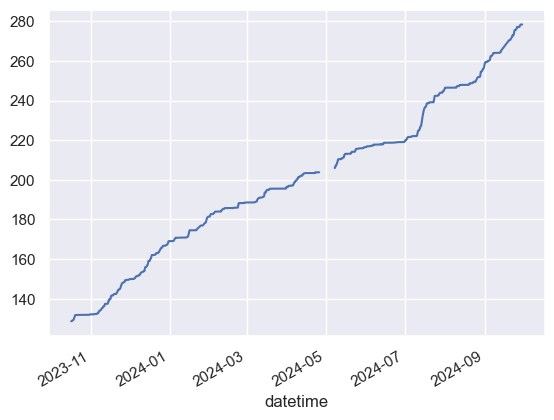

In [141]:
df_met['PCIRZZZ'].where(df_met['station'] == 'PPSA2').plot()

(0.0, 49.0)

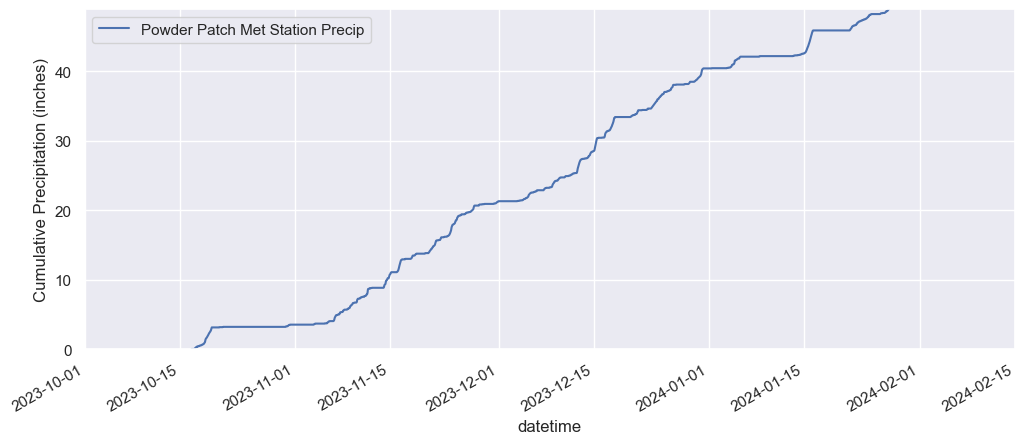

In [164]:
precip_plot = df_met['PCIRZZZ'].where(df_met['station'] == 'PPSA2')
precip_plot = precip_plot - precip_plot.min()
precip_plot.plot(figsize=(12, 5), label='Powder Patch Met Station Precip')

start_date = '2023-10-01'
end_date = '2024-02-15'
plt.xlim(pd.Timestamp(start_date), pd.Timestamp(end_date))
plt.ylabel('Cumulative Precipitation (inches)')
plt.legend()
plt.ylim(0,49)

<Axes: title={'center': 'Hourly Precipitation at Powder Patch'}, xlabel='datetime'>

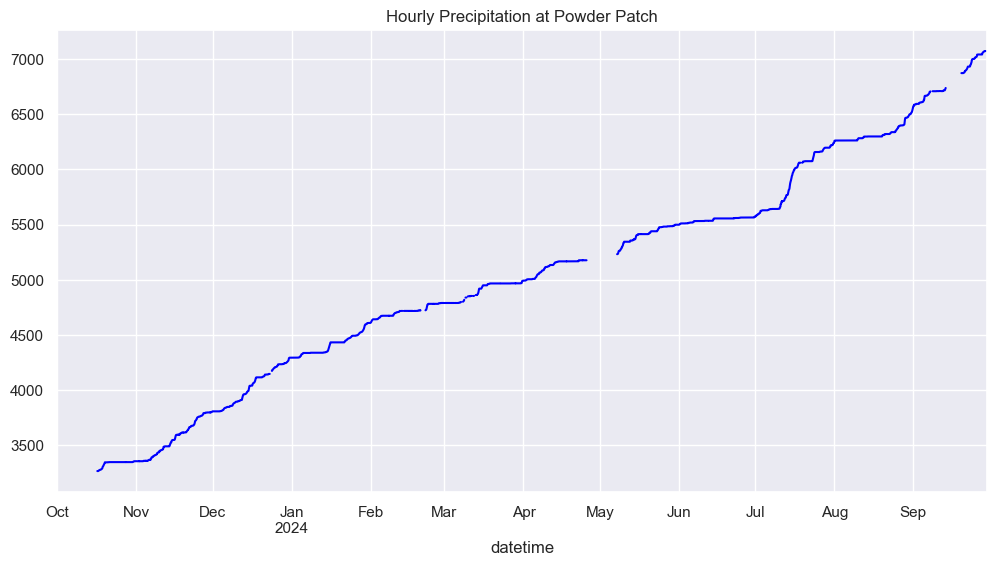

In [147]:
df_precip['PC_PPSA2'].plot(label='PC_PPSA2', color='blue', figsize=(12, 6), title='Hourly Precipitation at Powder Patch')

<Axes: title={'center': 'Hourly Precipitation at Powder Patch'}, xlabel='datetime'>

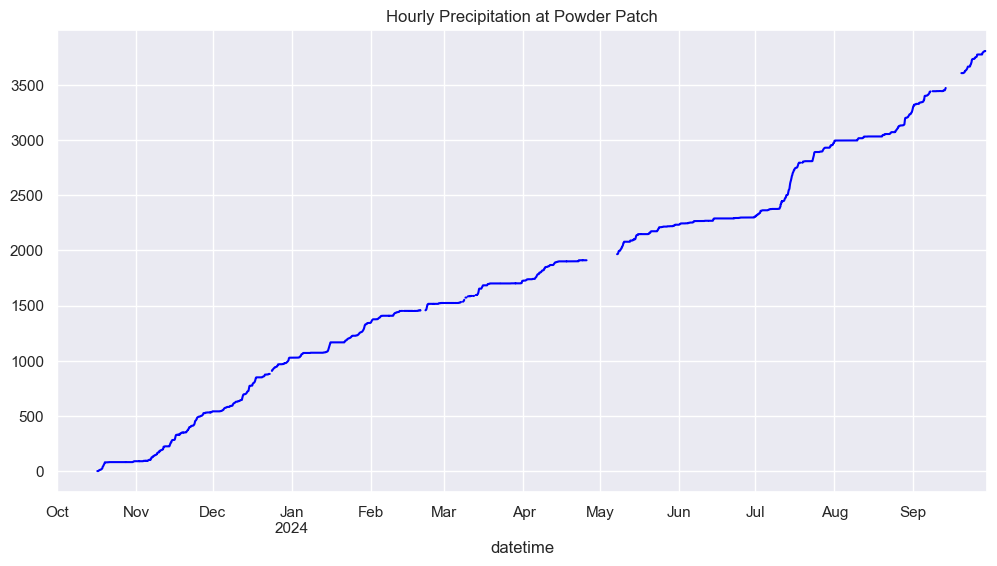

In [148]:
#subtract the smallest value from the cumulative precipitation to make it start at 0
df_precip['PC_PPSA2'] = df_precip['PC_PPSA2'] - df_precip['PC_PPSA2'].min()
df_precip['PC_PPSA2'].plot(label='PC_PPSA2', color='blue', figsize=(12, 6), title='Hourly Precipitation at Powder Patch')

## LOAD 2025